In [ ]:
%pip install captum
%pip install Flask-Compress
%pip install pytorch-lightning
%pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torch.nn as nn

import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/CAPTUM_methods'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Labs/Computer Vision/CAPTUM_methods


In [ ]:
%ls

captum_methods_included.txt          __pycache__/
cav/                                 saved_models/
Data/                                tcav_data/
draft.ipynb                          tensorboard_logs/
imagenet/                            transfer_learning_tcav_captum.ipynb
model_transfer_learning_trainned.py  transfer_learning_xai_captum.ipynb
prepare_tcav_data.ipynb


## Image related transformations and functions

In [ ]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(384),
            transforms.CenterCrop(384),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


In [ ]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='tcav_data/image/oxford_pets/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)

    return tensors


Defining a helper function to load predefined concepts. `assemble_concept` function reads the concepts using a directory path where the concepts are residing and constructs concept object.

In [ ]:
def assemble_concept(name, id, concepts_path="tcav_data/image/concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)


### Define the Tcav concepts used

In [ ]:
concepts_path = "tcav_data/image/concepts/"

blotchy_concept = assemble_concept("blotchy", 0, concepts_path=concepts_path)
braided_concept = assemble_concept("braided", 1, concepts_path=concepts_path)
dotted_concept  = assemble_concept("dotted", 2,   concepts_path=concepts_path)
fibrous_concept = assemble_concept("fibrous", 3, concepts_path=concepts_path)
flecked_concept = assemble_concept("flecked", 4, concepts_path=concepts_path)
matted_concept  = assemble_concept("matted", 5,   concepts_path=concepts_path)
striped_concept = assemble_concept("striped", 6, concepts_path=concepts_path)
woven_concept   = assemble_concept("woven", 7,     concepts_path=concepts_path)
wrinkled_concept = assemble_concept("wrinkled", 8, concepts_path=concepts_path)


random_0_concept = assemble_concept("random_0", 9,  concepts_path=concepts_path)
random_1_concept = assemble_concept("random_1", 10, concepts_path=concepts_path)
random_2_concept = assemble_concept("random_2", 11, concepts_path=concepts_path)
random_3_concept = assemble_concept("random_3", 12, concepts_path=concepts_path)
random_4_concept = assemble_concept("random_4", 13, concepts_path=concepts_path)

In [ ]:
n_figs = 5
n_concepts = 11

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([blotchy_concept,braided_concept,dotted_concept, fibrous_concept,flecked_concept,matted_concept,striped_concept, woven_concept, wrinkled_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
batch_size=8


train_dataset_raw = torchvision.datasets.OxfordIIITPet(
        root="Data",target_types='category', transform=transforms.Compose([ transforms.Resize(236),transforms.CenterCrop(228),transforms.ToTensor()]), download=True
    )

train_loader_raw = DataLoader(
        dataset=train_dataset_raw,
        batch_size=batch_size,
        shuffle=True
    )

dataset_labels=train_dataset_raw.class_to_idx.keys()
print('Categories of the dataset:\n',  ','.join(dataset_labels))


Categories of the dataset:
 Abyssinian,American Bulldog,American Pit Bull Terrier,Basset Hound,Beagle,Bengal,Birman,Bombay,Boxer,British Shorthair,Chihuahua,Egyptian Mau,English Cocker Spaniel,English Setter,German Shorthaired,Great Pyrenees,Havanese,Japanese Chin,Keeshond,Leonberger,Maine Coon,Miniature Pinscher,Newfoundland,Persian,Pomeranian,Pug,Ragdoll,Russian Blue,Saint Bernard,Samoyed,Scottish Terrier,Shiba Inu,Siamese,Sphynx,Staffordshire Bull Terrier,Wheaten Terrier,Yorkshire Terrier


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

## Defining EfficientNet Model

In [ ]:
from torchinfo import summary
from model_transfer_learning_trainned import model


# Do a summary *after* freezing the features and changing the output classifier layer
summary(model,
        input_size=(8, 3, 384, 384),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=['depth',"var_names"],
        mode='train'
)

The inout of the model are transformed with: 
ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Categories of the dataset:
 Abyssinian,American Bulldog,American Pit Bull Terrier,Basset Hound,Beagle,Bengal,Birman,Bombay,Boxer,British Shorthair,Chihuahua,Egyptian Mau,English Cocker Spaniel,English Setter,German Shorthaired,Great Pyrenees,Havanese,Japanese Chin,Keeshond,Leonberger,Maine Coon,Miniature Pinscher,Newfoundland,Persian,Pomeranian,Pug,Ragdoll,Russian Blue,Saint Bernard,Samoyed,Scottish Terrier,Shiba Inu,Siamese,Sphynx,Staffordshire Bull Terrier,Wheaten Terrier,Yorkshire Terrier


INFO:lightning_lite.utilities.seed:Global seed set to 42


device:  cpu


Layer (type (var_name):depth-idx)                                      Input Shape          Output Shape         Param #              Trainable
OxfordIIITPetModule (OxfordIIITPetModule)                              [8, 3, 384, 384]     [8, 37]              --                   False
├─EfficientNet (model): 1-1                                            [8, 3, 384, 384]     [8, 37]              --                   False
│    └─Sequential (features): 2-1                                      [8, 3, 384, 384]     [8, 1280, 12, 12]    --                   False
│    │    └─Conv2dNormActivation (0): 3-1                              [8, 3, 384, 384]     [8, 24, 192, 192]    (696)                False
│    │    └─Sequential (1): 3-2                                        [8, 24, 192, 192]    [8, 24, 192, 192]    (10,464)             False
│    │    └─Sequential (2): 3-3                                        [8, 24, 192, 192]    [8, 48, 96, 96]      (303,552)            False
│    │    └─Sequ

# Setting TCAV experiment

In [ ]:
model.model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=37, bias=True)
)

In [ ]:
#is very long
#model.model.features

##### Defining experimantal sets for CAV

In [ ]:
experimental_set_rand_1 = [[blotchy_concept,random_0_concept], [braided_concept, random_1_concept],[dotted_concept, random_2_concept]]
experimental_set_rand_2 = [[fibrous_concept, random_3_concept],[flecked_concept, random_4_concept],[matted_concept, random_0_concept]]
experimental_set_rand_3 = [[striped_concept, random_1_concept],[woven_concept, random_2_concept],[wrinkled_concept, random_3_concept]]

print(experimental_set_rand_1)
print(experimental_set_rand_2)
print(experimental_set_rand_3)

[[Concept(0, 'blotchy'), Concept(9, 'random_0')], [Concept(1, 'braided'), Concept(10, 'random_1')], [Concept(2, 'dotted'), Concept(11, 'random_2')]]
[[Concept(3, 'fibrous'), Concept(12, 'random_3')], [Concept(4, 'flecked'), Concept(13, 'random_4')], [Concept(5, 'matted'), Concept(9, 'random_0')]]
[[Concept(6, 'striped'), Concept(10, 'random_1')], [Concept(7, 'woven'), Concept(11, 'random_2')], [Concept(8, 'wrinkled'), Concept(12, 'random_3')]]


Auxiliary functions for visualizing of TCAV scores.

In [ ]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):
        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

In [ ]:
def run_tcav(layers, inputs, model=model.model):

  mytcav = TCAV(model=model,
                  layers=layers,
                  layer_attr_method = LayerIntegratedGradients(
                          model, None, multiply_by_inputs=False))

  cats_ind = 20

  tcav_scores_layer_features_w_random_1 = mytcav.interpret(inputs=cats_tensors,
                                          experimental_sets=experimental_set_rand_1,
                                          target=cats_ind,
                                          n_steps=7
                                        )

  tcav_scores_layer_features_w_random_2 = mytcav.interpret(inputs=cats_tensors,
                                          experimental_sets=experimental_set_rand_2,
                                          target=cats_ind,
                                          n_steps=7
                                        )

  tcav_scores_layer_features_w_random_3 = mytcav.interpret(inputs=cats_tensors,
                                          experimental_sets=experimental_set_rand_3,
                                          target=cats_ind,
                                          n_steps=7
                                        )

  return tcav_scores_layer_features_w_random_1, tcav_scores_layer_features_w_random_2, tcav_scores_layer_features_w_random_3

# TCAV experiment for cats data

In [ ]:
# Load sample images from folder
cats_imgs = load_image_tensors('cats', transform=False)

In [ ]:
len(cats_imgs)

48

Visualizing some of the images use for  explaining

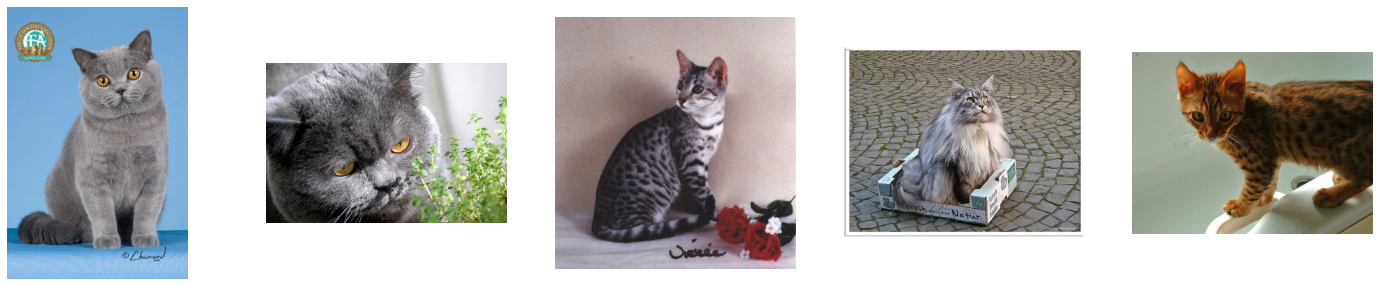

In [ ]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(cats_imgs[40])
axs[1].imshow(cats_imgs[41])
axs[2].imshow(cats_imgs[34])
axs[3].imshow(cats_imgs[31])
axs[4].imshow(cats_imgs[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

Here we perform a transformation and convert the images into tensors, so that we can use them as inputs to NN model.

In [ ]:
# Load sample images from folder
cats_tensors = torch.stack([transform(img) for img in cats_imgs])

### TCAV experiment for features layer

In [ ]:
import pprint

layers=['features']

tcav_scores_layer_features_w_random_1, tcav_scores_layer_features_w_random_2, tcav_scores_layer_features_w_random_3 = run_tcav(layers = layers, inputs=cats_tensors)

pprint.pprint(tcav_scores_layer_features_w_random_1)
pprint.pprint(tcav_scores_layer_features_w_random_2)
pprint.pprint(tcav_scores_layer_features_w_random_3)

/usr/local/lib/python3.8/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f93191e4d30>,
            {'0-9': defaultdict(None,
                                {'features': {'magnitude': tensor([-0.0860,  0.0860]),
                                              'sign_count': tensor([0., 1.])}}),
             '1-10': defaultdict(None,
                                 {'features': {'magnitude': tensor([-0.3252,  0.3252]),
                                               'sign_count': tensor([0., 1.])}}),
             '2-11': defaultdict(None,
                                 {'features': {'magnitude': tensor([ 2.8948, -2.8948]),
                                               'sign_count': tensor([1., 0.])}})})
defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f9312033f70>,
            {'3-12': defaultdict(None,
                                 {'features': {'magnitude': tensor([ 3.5042, -3.5042]),
                                               'sign_count': tensor([1., 0.])}}),
             '4-

Let's use above defined auxilary functions and visualize tcav scores below.

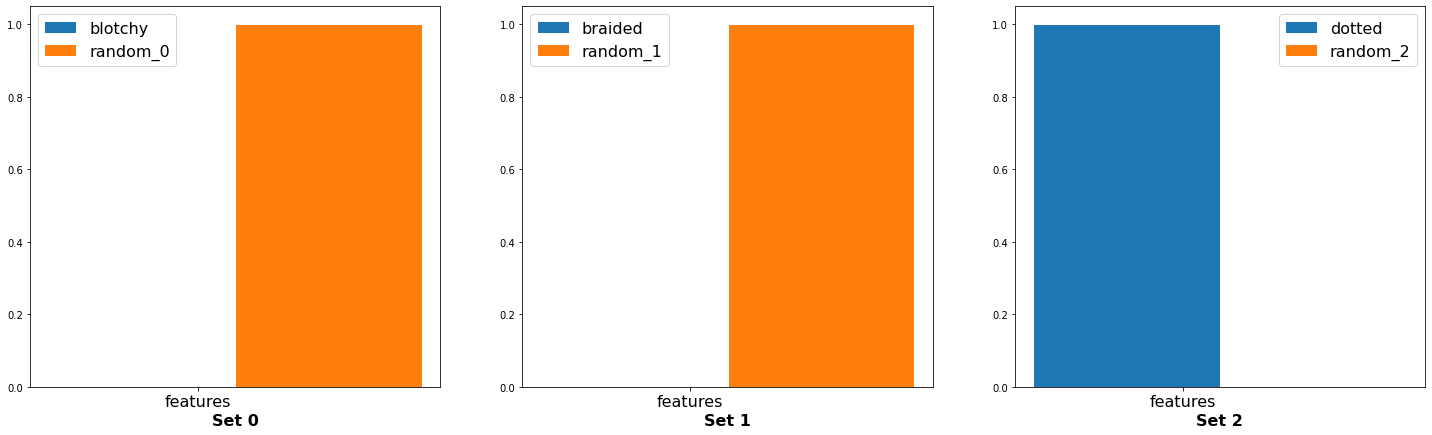

In [ ]:
plot_tcav_scores(experimental_set_rand_1, tcav_scores_layer_features_w_random_1)

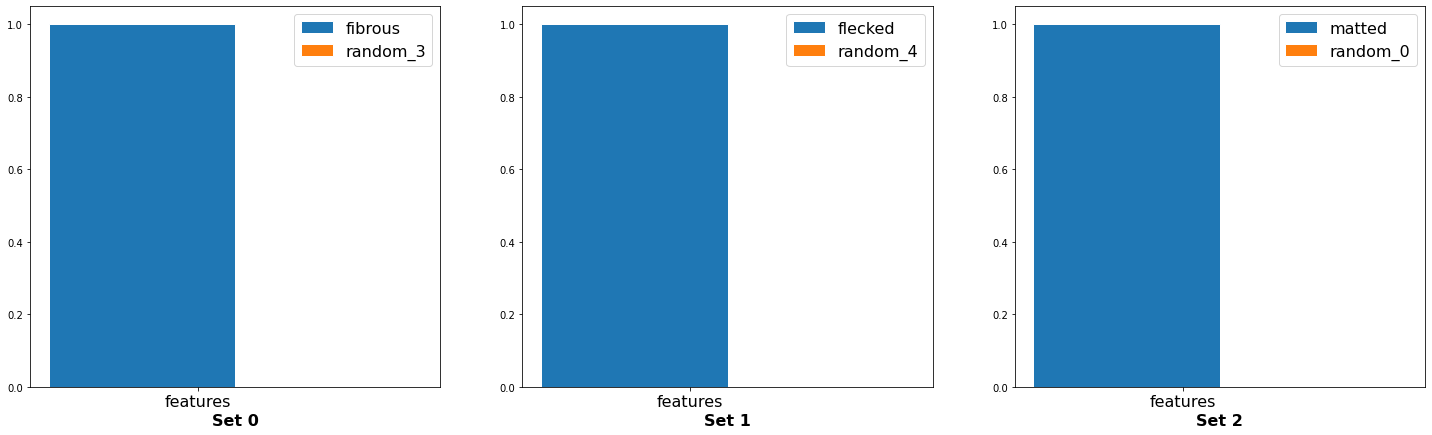

In [ ]:
plot_tcav_scores(experimental_set_rand_2, tcav_scores_layer_features_w_random_2)

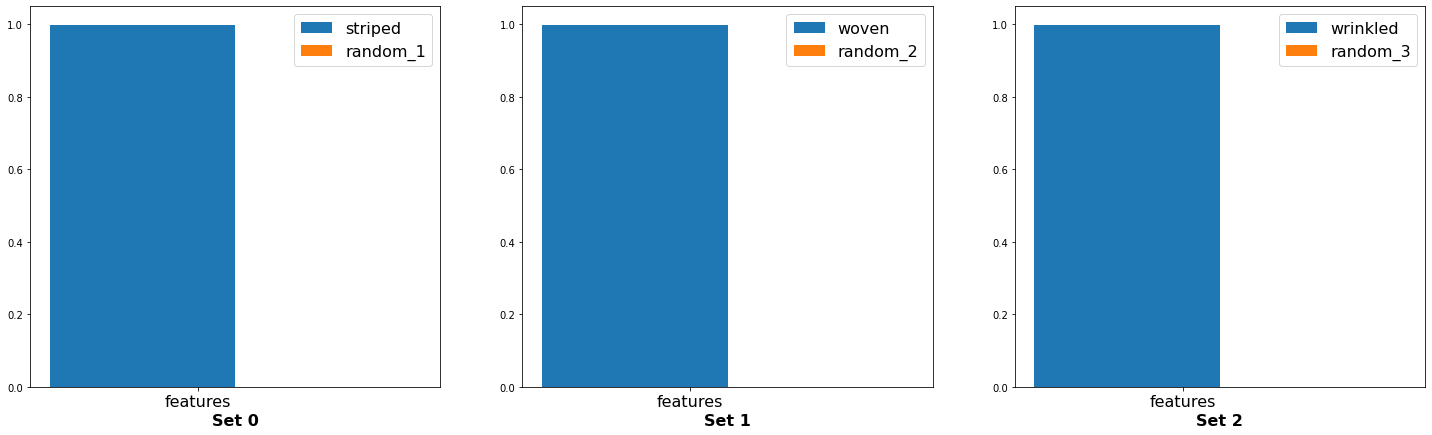

In [ ]:
plot_tcav_scores(experimental_set_rand_3, tcav_scores_layer_features_w_random_3)

### TCAV experiment for classifier layer

In [ ]:
layers=['classifier']

tcav_scores_layer_features_w_random_1, tcav_scores_layer_features_w_random_2, tcav_scores_layer_features_w_random_3 = run_tcav(layers = layers, inputs=cats_tensors)

pprint.pprint(tcav_scores_layer_features_w_random_1)
pprint.pprint(tcav_scores_layer_features_w_random_2)
pprint.pprint(tcav_scores_layer_features_w_random_3)

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f9317f9c700>,
            {'0-9': defaultdict(None,
                                {'classifier': {'magnitude': tensor([-0.4722,  0.4722]),
                                                'sign_count': tensor([0., 1.])}}),
             '1-10': defaultdict(None,
                                 {'classifier': {'magnitude': tensor([ 135.7089, -135.7089]),
                                                 'sign_count': tensor([1., 0.])}}),
             '2-11': defaultdict(None,
                                 {'classifier': {'magnitude': tensor([ 2.1754, -2.1754]),
                                                 'sign_count': tensor([1., 0.])}})})
defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f9317f9c8b0>,
            {'3-12': defaultdict(None,
                                 {'classifier': {'magnitude': tensor([ 14.6374, -14.6374]),
                                                 'sign_count': tensor([1., 0.]

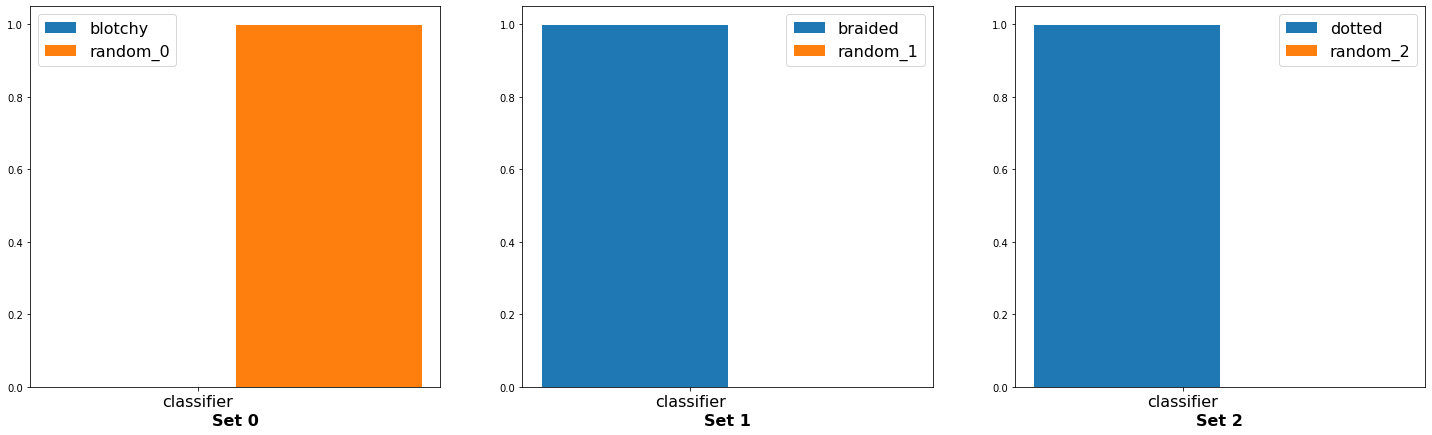

In [ ]:
plot_tcav_scores(experimental_set_rand_1, tcav_scores_layer_features_w_random_1)

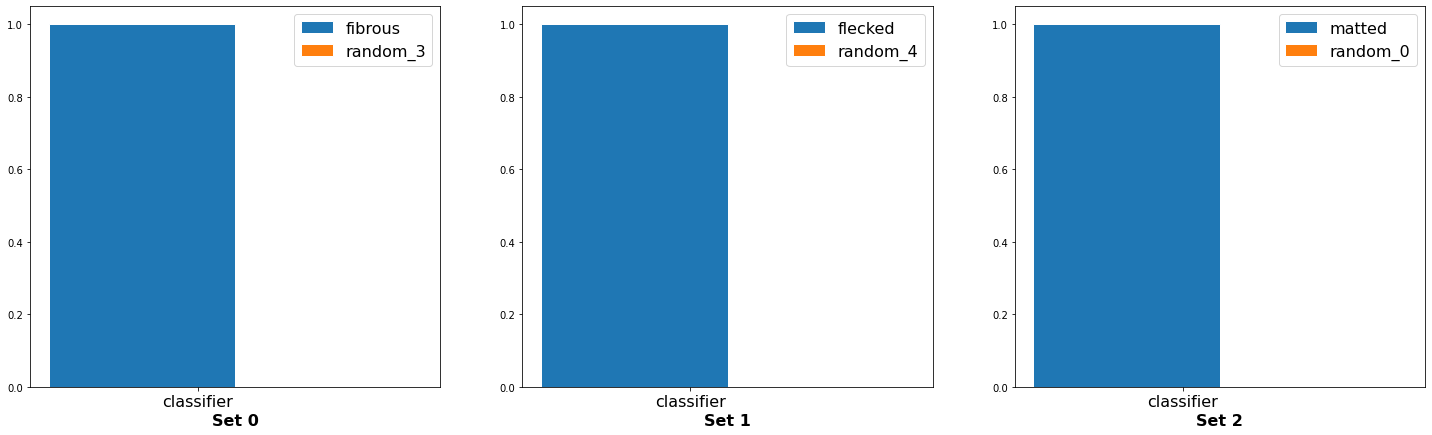

In [ ]:
plot_tcav_scores(experimental_set_rand_2, tcav_scores_layer_features_w_random_2)

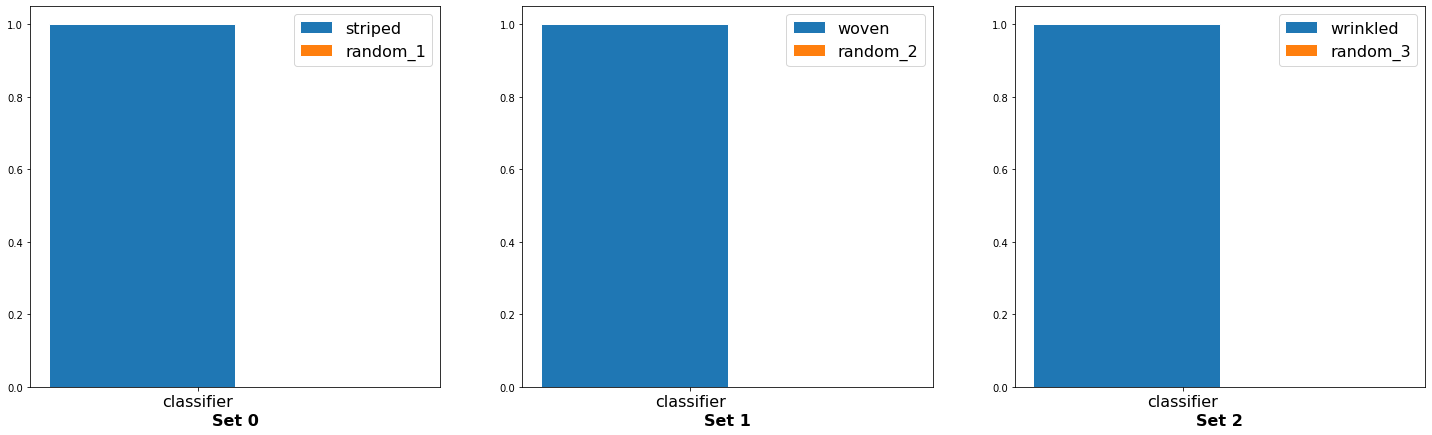

In [ ]:
plot_tcav_scores(experimental_set_rand_3, tcav_scores_layer_features_w_random_3)

Compute TCAV scores for a experimental set that contains all the different concepts.

#### TCAV experiment for all the concepts

In [ ]:
layers=['features']
experimental_set = [[blotchy_concept, braided_concept, dotted_concept, fibrous_concept, flecked_concept]]
cats_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=cats_tensors,
                                  experimental_sets=experimental_set,
                                  target=cats_ind,
                                  n_steps=7)
tcav_scores_set

/usr/local/lib/python3.8/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-1-2-3-4': defaultdict(None,
                         {'features': {'sign_count': tensor([0., 0., 0., 1., 1.]),
                           'magnitude': tensor([-2.9641, -1.3637, -1.4828,  3.1221,  3.2257])}})})

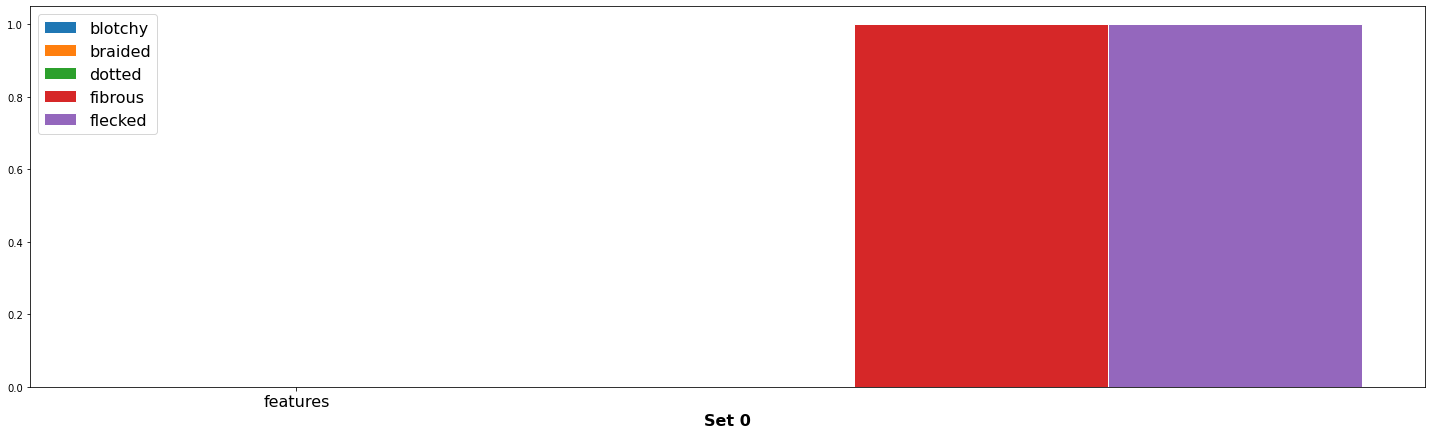

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)


In [ ]:
layers=['classifier']
experimental_set = [[blotchy_concept, braided_concept, dotted_concept, fibrous_concept, flecked_concept]]
cats_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=cats_tensors,
                                  experimental_sets=experimental_set,
                                  target=cats_ind,
                                  n_steps=7)
tcav_scores_set

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-1-2-3-4': defaultdict(None,
                         {'classifier': {'sign_count': tensor([0., 1., 0., 1., 0.]),
                           'magnitude': tensor([-0.5785,  0.9209, -0.5319,  1.3608, -0.8686])}})})

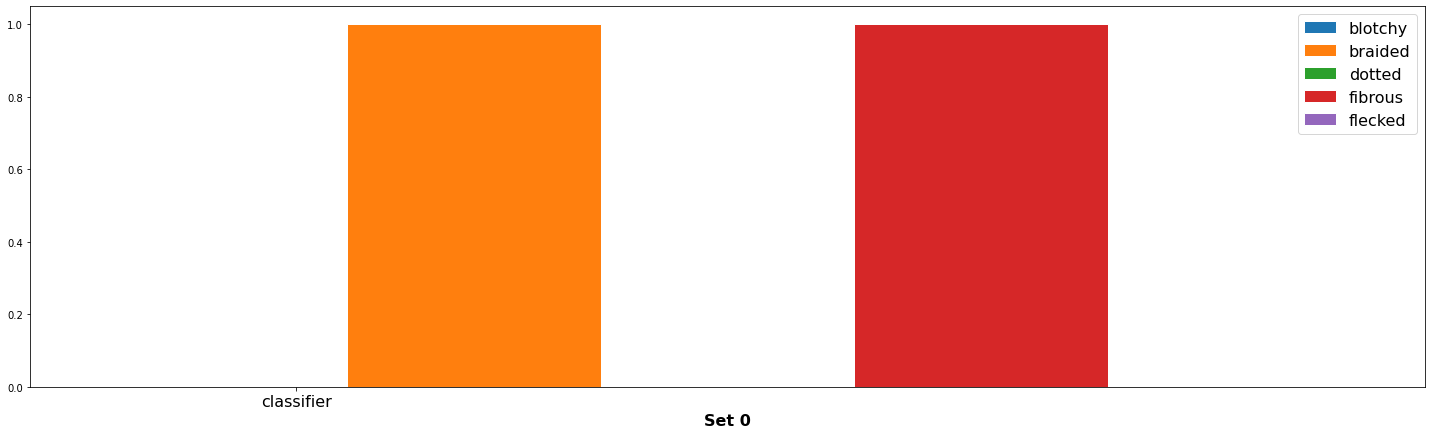

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)


In [ ]:
layers=['features']
experimental_set = [[ matted_concept, striped_concept, woven_concept, wrinkled_concept]]
cats_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=cats_tensors,
                                  experimental_sets=experimental_set,
                                  target=cats_ind,
                                  n_steps=7)
tcav_scores_set

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'5-6-7-8': defaultdict(None,
                         {'features': {'sign_count': tensor([0., 0., 1., 1.]),
                           'magnitude': tensor([-2.4157, -1.2848,  2.3632,  3.1121])}})})

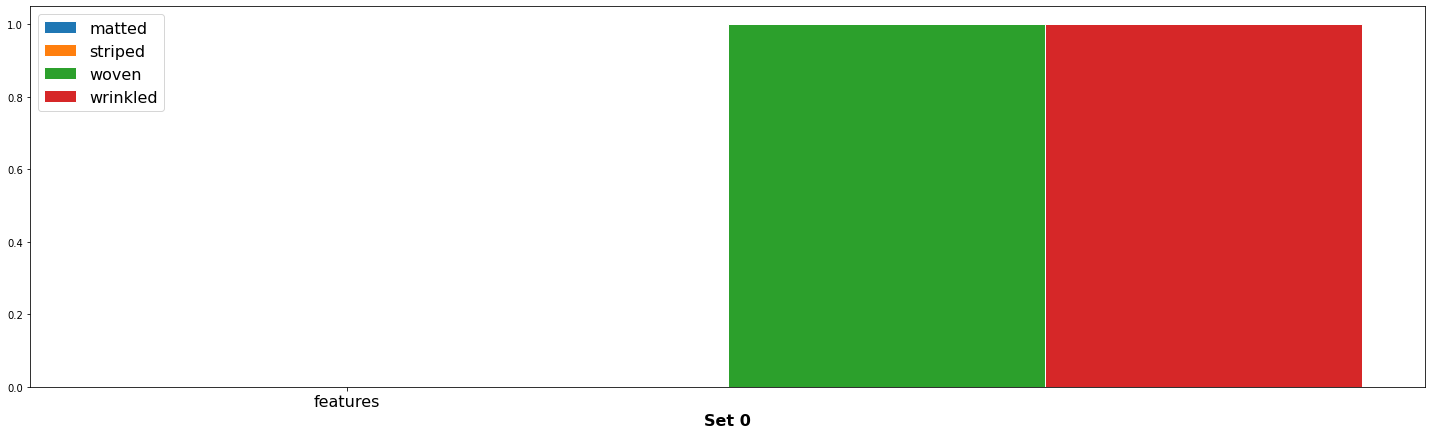

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)

In [ ]:
layers=['classifier']
experimental_set = [[ matted_concept, striped_concept, woven_concept, wrinkled_concept]]
cats_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=cats_tensors,
                                  experimental_sets=experimental_set,
                                  target=cats_ind,
                                  n_steps=7)
tcav_scores_set


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'5-6-7-8': defaultdict(None,
                         {'classifier': {'sign_count': tensor([0., 0., 1., 1.]),
                           'magnitude': tensor([-2.1924, -0.7290,  3.1657,  2.4095])}})})

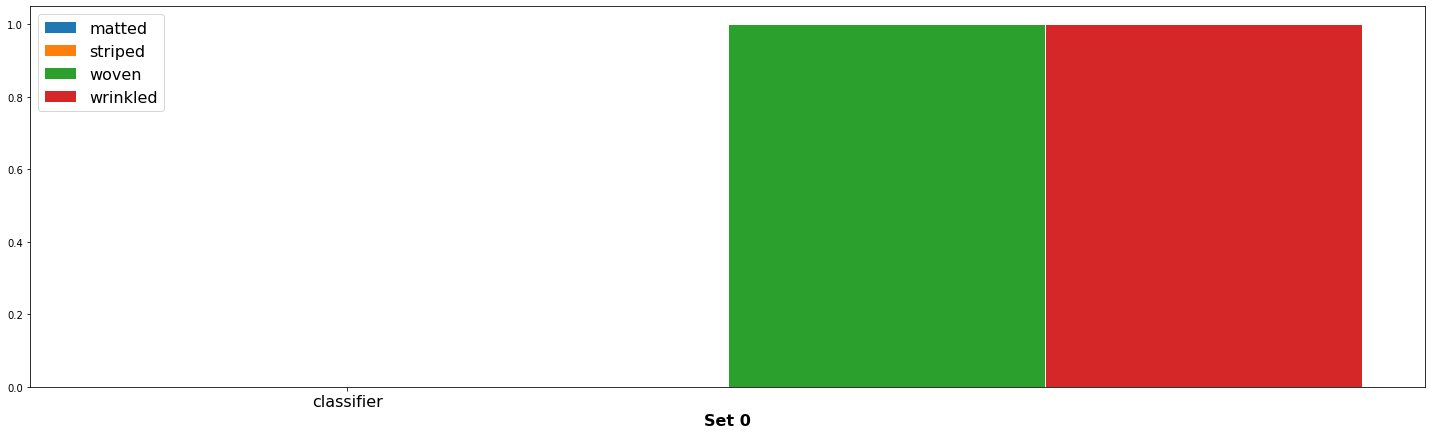

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)

# TCAV experiment for dogs data

### TCAV experiment for features layer

In [ ]:
# Load sample images from folder
dogs_imgs = load_image_tensors('dogs', transform=False)

In [ ]:
len(dogs_imgs)

51

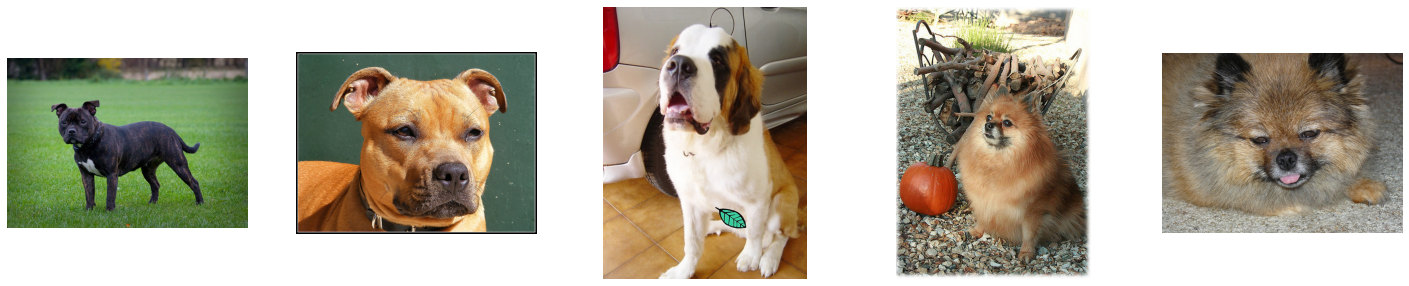

In [ ]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(dogs_imgs[40])
axs[1].imshow(dogs_imgs[41])
axs[2].imshow(dogs_imgs[34])
axs[3].imshow(dogs_imgs[31])
axs[4].imshow(dogs_imgs[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [ ]:
# Load sample images from folder
dogs_tensors = torch.stack([transform(img) for img in dogs_imgs])

### TCAV experiment for features layer

In [ ]:
import pprint

layers=['features']

tcav_scores_layer_features_w_random_1, tcav_scores_layer_features_w_random_2, tcav_scores_layer_features_w_random_3 = run_tcav(layers = layers, inputs=dogs_tensors)

pprint.pprint(tcav_scores_layer_features_w_random_1)
pprint.pprint(tcav_scores_layer_features_w_random_2)
pprint.pprint(tcav_scores_layer_features_w_random_3)

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f669268e3a0>,
            {'0-9': defaultdict(None,
                                {'features': {'magnitude': tensor([-0.0860,  0.0860]),
                                              'sign_count': tensor([0., 1.])}}),
             '1-10': defaultdict(None,
                                 {'features': {'magnitude': tensor([-0.3252,  0.3252]),
                                               'sign_count': tensor([0., 1.])}}),
             '2-11': defaultdict(None,
                                 {'features': {'magnitude': tensor([ 2.8948, -2.8948]),
                                               'sign_count': tensor([1., 0.])}})})
defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f669268e5e0>,
            {'3-12': defaultdict(None,
                                 {'features': {'magnitude': tensor([ 3.5042, -3.5042]),
                                               'sign_count': tensor([1., 0.])}}),
             '4-

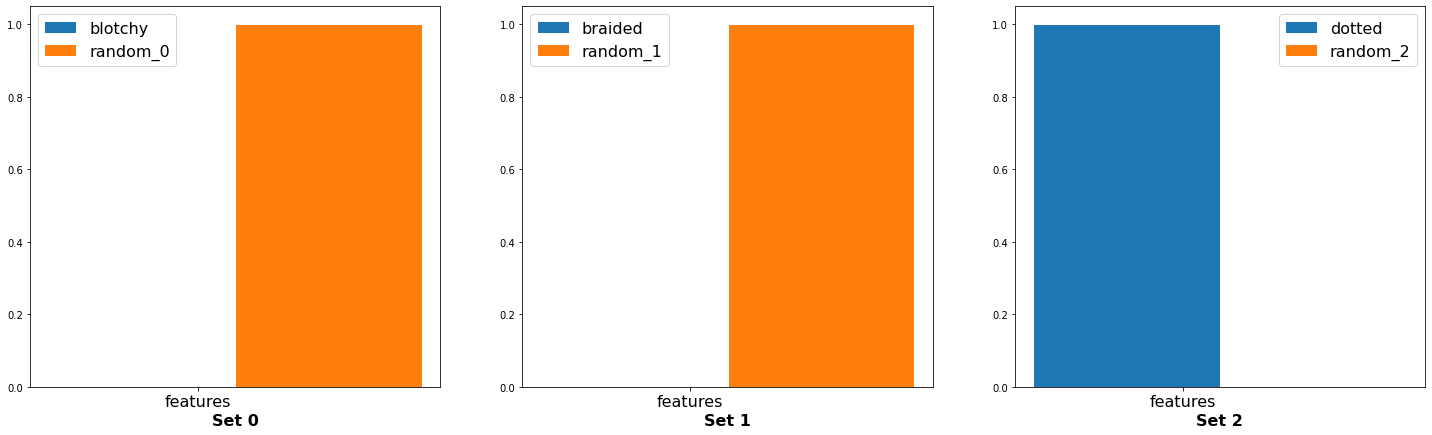

In [ ]:
plot_tcav_scores(experimental_set_rand_1, tcav_scores_layer_features_w_random_1)

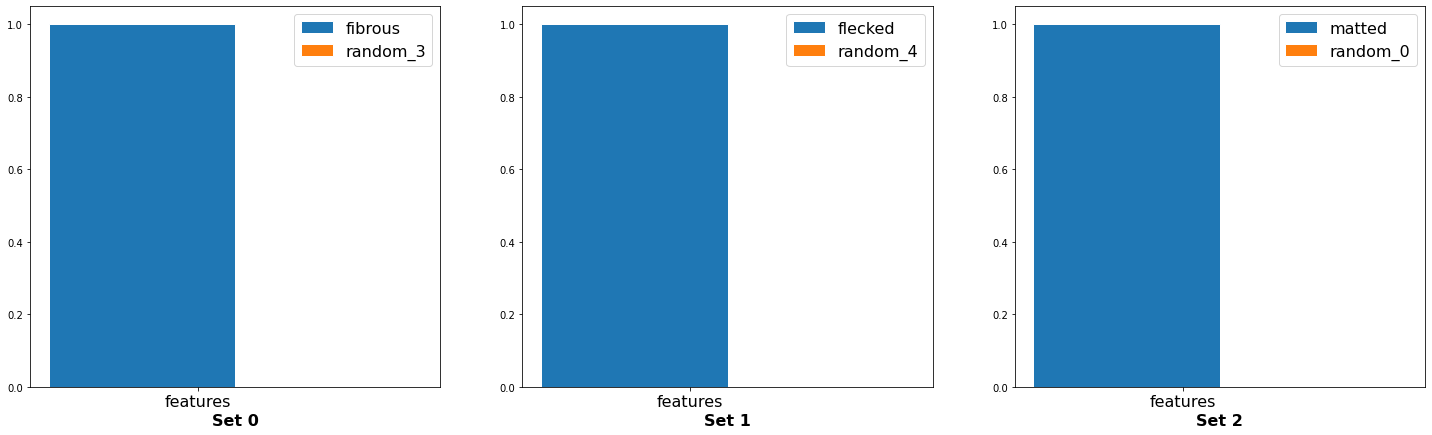

In [ ]:
plot_tcav_scores(experimental_set_rand_2, tcav_scores_layer_features_w_random_2)

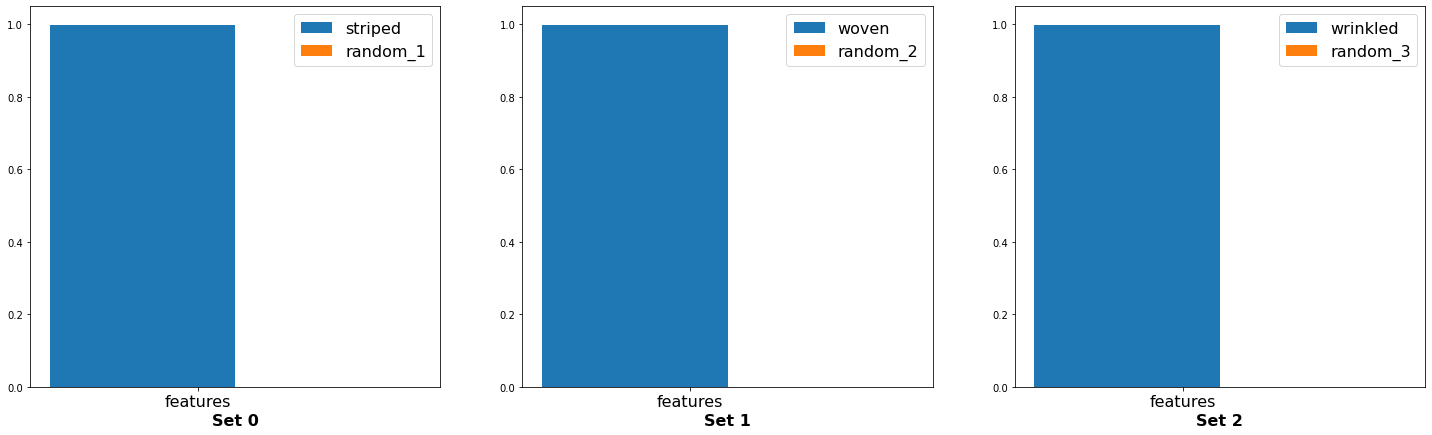

In [ ]:
plot_tcav_scores(experimental_set_rand_3, tcav_scores_layer_features_w_random_3)

### TCAV experiment for clasifier layer

In [ ]:
layers=['classifier']

tcav_scores_layer_features_w_random_1, tcav_scores_layer_features_w_random_2, tcav_scores_layer_features_w_random_3 = run_tcav(layers = layers, inputs=dogs_tensors)

pprint.pprint(tcav_scores_layer_features_w_random_1)
pprint.pprint(tcav_scores_layer_features_w_random_2)
pprint.pprint(tcav_scores_layer_features_w_random_3)

defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f6692cb1af0>,
            {'0-9': defaultdict(None,
                                {'classifier': {'magnitude': tensor([-0.4722,  0.4722]),
                                                'sign_count': tensor([0., 1.])}}),
             '1-10': defaultdict(None,
                                 {'classifier': {'magnitude': tensor([ 135.7089, -135.7089]),
                                                 'sign_count': tensor([1., 0.])}}),
             '2-11': defaultdict(None,
                                 {'classifier': {'magnitude': tensor([ 2.1754, -2.1754]),
                                                 'sign_count': tensor([1., 0.])}})})
defaultdict(<function TCAV.interpret.<locals>.<lambda> at 0x7f6689bbfdc0>,
            {'3-12': defaultdict(None,
                                 {'classifier': {'magnitude': tensor([ 14.6374, -14.6374]),
                                                 'sign_count': tensor([1., 0.]

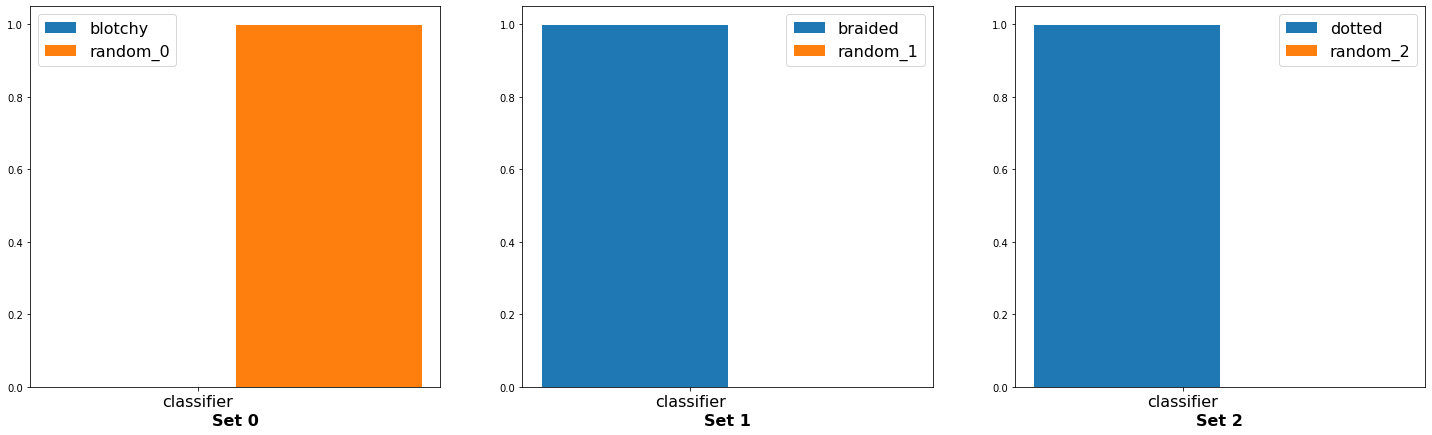

In [ ]:
plot_tcav_scores(experimental_set_rand_1, tcav_scores_layer_features_w_random_1)

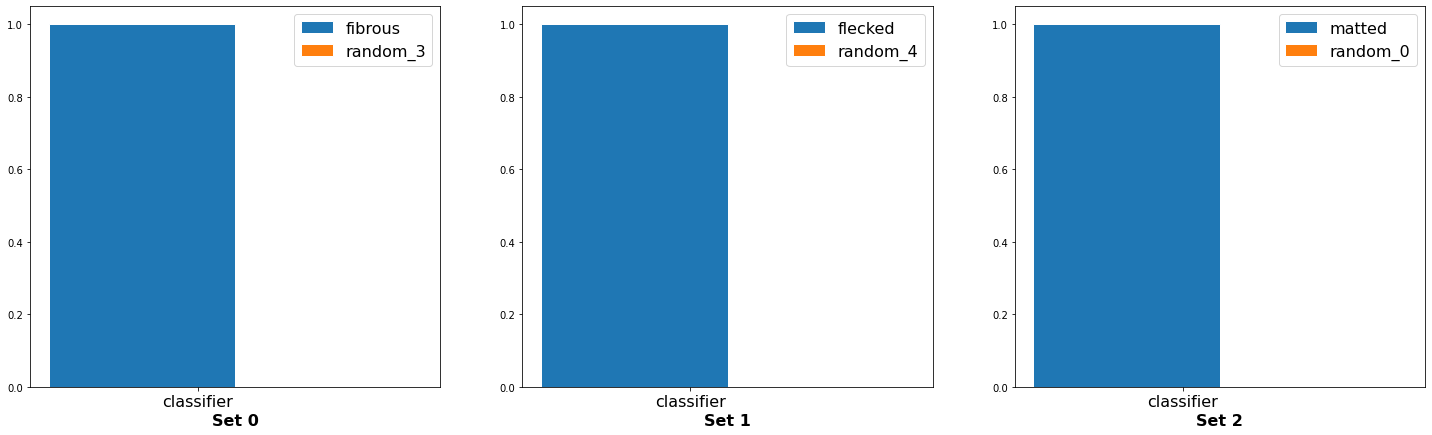

In [ ]:
plot_tcav_scores(experimental_set_rand_2, tcav_scores_layer_features_w_random_2)

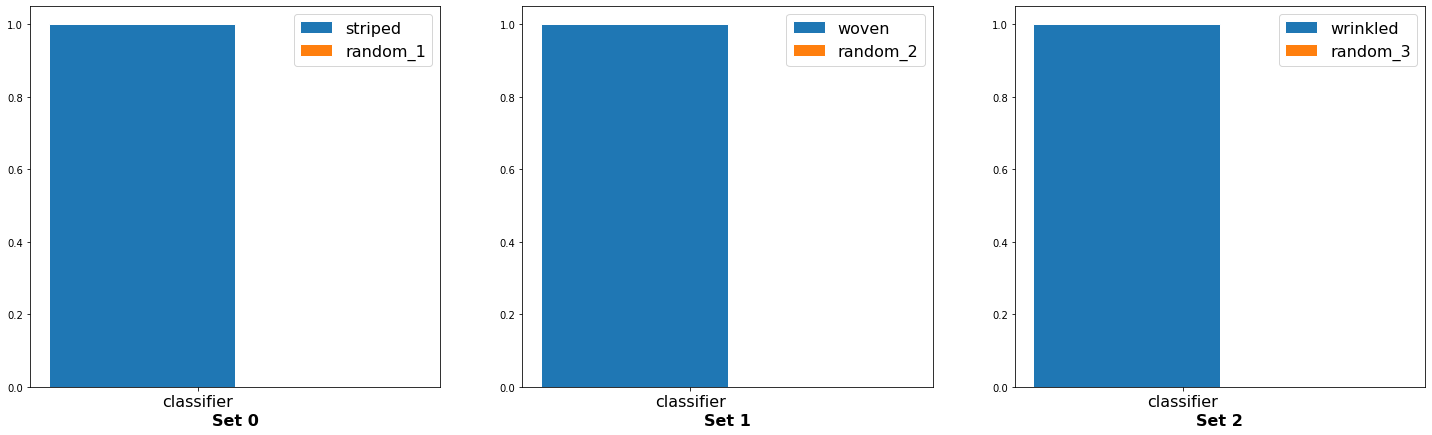

In [ ]:
plot_tcav_scores(experimental_set_rand_3, tcav_scores_layer_features_w_random_3)

From the plots above we can see that the concepts : dotted_concept,  fibrous_concept, flecked_concept, matted_concept, striped_concept, woven_concept, wrinkled_concept are important for features layers and concept layer. The concepts blotchy_concept and braided_concept are not important for features layers.
But braided_concept is important only for the concept layer because the transfer learning was performed for the concept layer. braided_concept represents patterns that blend very well with fur. This concept could had been learnt by the classifier layer because it was trainned on the data that has many races of dogs and cats.


#### TCAV experiment for all the concepts

In [ ]:
layers=['features']
experimental_set = [[blotchy_concept, braided_concept, dotted_concept]]
dogs_ind = 22

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=dogs_tensors,
                                  experimental_sets=experimental_set,
                                  target=dogs_ind,
                                  n_steps=7)
tcav_scores_set

/usr/local/lib/python3.8/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/captum/_utils/models/linear_model/train.py:351: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-1-2': defaultdict(None,
                         {'features': {'sign_count': tensor([1., 0., 0.]),
                           'magnitude': tensor([ 4.3441, -4.6550, -0.2422])}})})

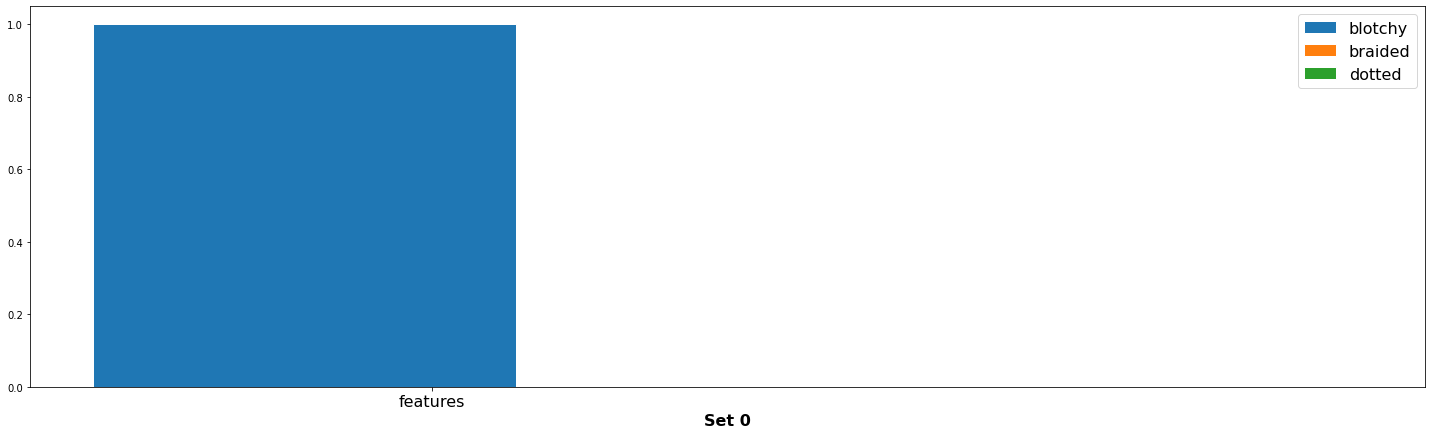

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)

In [ ]:
layers=['classifier']
experimental_set = [[blotchy_concept, braided_concept, dotted_concept, fibrous_concept, flecked_concept]]
dogs_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=dogs_tensors,
                                  experimental_sets=experimental_set,
                                  target=dogs_ind,
                                  n_steps=7)
tcav_scores_set

/usr/local/lib/python3.8/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-1-2-3-4': defaultdict(None,
                         {'classifier': {'sign_count': tensor([0., 1., 0., 1., 0.]),
                           'magnitude': tensor([-0.5785,  0.9209, -0.5319,  1.3608, -0.8686])}})})

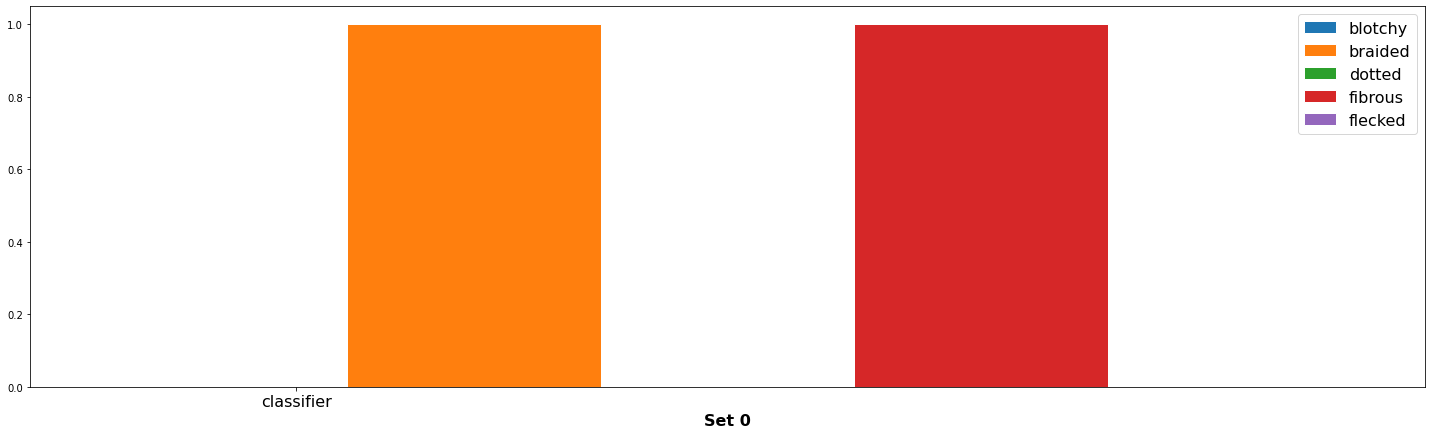

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)

In [ ]:
layers=['features']
experimental_set = [[fibrous_concept,flecked_concept, matted_concept, striped_concept, woven_concept, wrinkled_concept]]
dogs_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=dogs_tensors,
                                  experimental_sets=experimental_set,
                                  target=dogs_ind,
                                  n_steps=7)
tcav_scores_set

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'3-4-5-6-7-8': defaultdict(None,
                         {'features': {'sign_count': tensor([1., 0., 1., 0., 1., 0.]),
                           'magnitude': tensor([ 0.6183, -1.2148,  0.2173, -0.7176,  1.2809, -1.2046])}})})

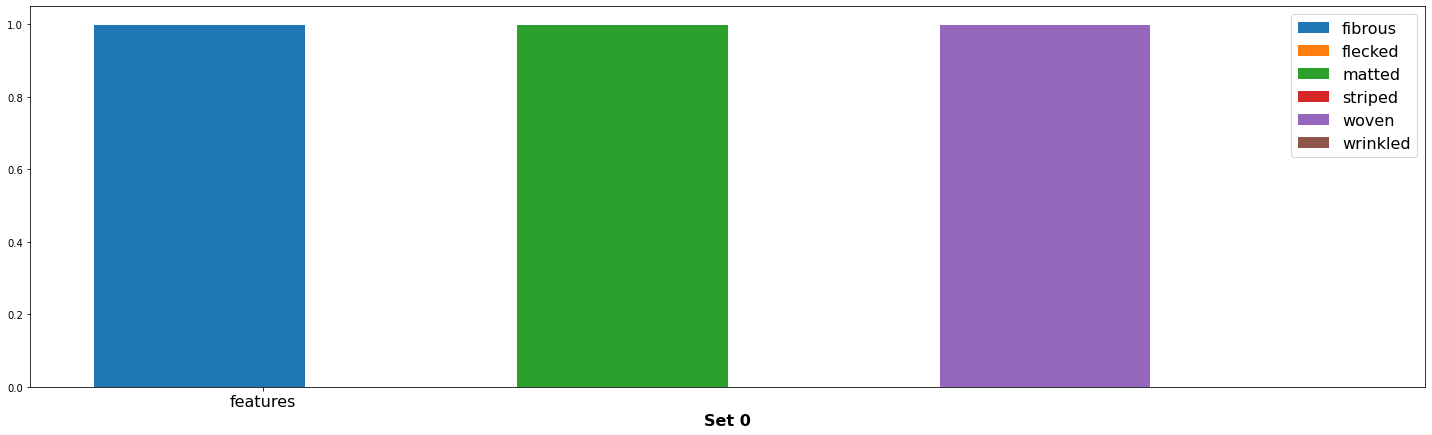

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)

In [ ]:
layers=['classifier']
experimental_set = [[ matted_concept, striped_concept, woven_concept, wrinkled_concept]]
dogs_ind = 20

mytcav = TCAV(model=model.model,
                  layers=layers,
                  layer_attr_method= LayerIntegratedGradients(
                          model.model, None, multiply_by_inputs=False))

tcav_scores_set = mytcav.interpret(inputs=dogs_tensors,
                                  experimental_sets=experimental_set,
                                  target=dogs_ind,
                                  n_steps=7)
tcav_scores_set

/usr/local/lib/python3.8/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'5-6-7-8': defaultdict(None,
                         {'classifier': {'sign_count': tensor([0., 0., 1., 1.]),
                           'magnitude': tensor([-2.1924, -0.7290,  3.1657,  2.4095])}})})

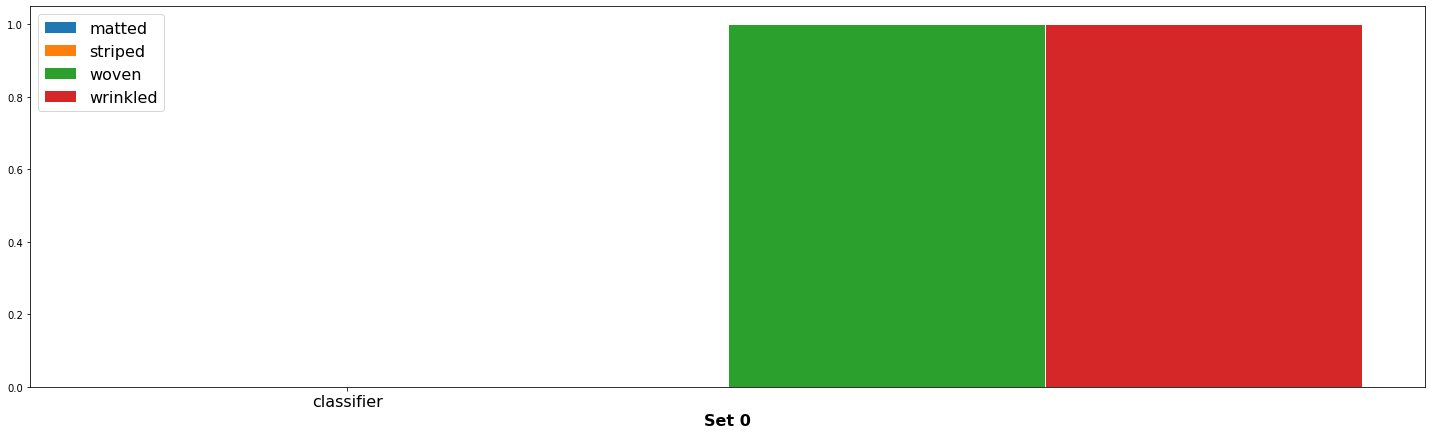

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores_set)